In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

Загрузим данные:

In [2]:
data = pd.read_csv('data.csv', quotechar="'", encoding = "windows-1251")

In [3]:
data.head()

,"""Количество больничных дней","""""Возраст""""","""""Пол"""""""
0,"""5",39,"""""Ж"""""""
1,"""4",54,"""""М"""""""
2,"""4",26,"""""М"""""""
3,"""5",42,"""""М"""""""
4,"""4",29,"""""М"""""""


In [4]:
columns_rename = {'"Количество больничных дней': 'work_days', '""Возраст""': 'age', '""Пол"""': 'gender'}

In [5]:
data = (
    data.rename(columns=columns_rename)
        .assign(work_days=lambda x: x['work_days'].str.replace('"', '').astype(int),
                gender=lambda x: x['gender'].str.replace('"', ''))
)

При проверке гипотез будем брать уровень значимости равным 0.05

## Проверим наличие зависимостей

Прежде всего хочется проверить, есть ли связь между кол-вом пропусков по больничному и пола/возраста. Для этого создадим таблицу
частот пропусков от пола/возраста. Сформулируем гипотезу $H_0$ - кол-во пропусков не зависит от пола.
Проверим гипотезу критерием согласия Пирсона

### Зависимость пропусков от пола

In [6]:
gender_days = pd.crosstab(data.gender, data.work_days > 2)
gender_days

work_days,False,True
gender,,
Ж,31,67
М,55,84


Критерий Пирсона:

In [7]:
stats, pvalue, _, _ = chi2_contingency(gender_days)
print(f'pvalue: {pvalue}')

pvalue: 0.26524443198654923


Значение pvalue получилось больше уровня значимости, значит мы не можем отклонить гипотезу $H_0$. Получается, что
частота пропусков не зависит от пола

### Зависимость пропусков от возраста

Всё аналогично предыдущей гипотезе. $H_0$ - кол-во пропусков не зависит от возраста (больше или меньше 35)

In [8]:
# Добавим столбец
data['>35'] = data.age > 35

In [9]:
age_days = pd.crosstab(data['>35'], data.work_days > 2)
age_days

work_days,False,True
>35,,
False,21,36
True,65,115


In [10]:
stats, pvalue, _, _ = chi2_contingency(age_days)
print(f'pvalue: {pvalue}')

pvalue: 1.0


Значение pvalue получилось больше уровня значимости, значит мы не можем отклонить гипотезу $H_0$. Получается, что
частота пропусков не зависит от возраста (больше или меньше 35).

Мы проверили частоту пропусков просто сравнивая кол-во пропусков по конкретной группе (возраст или пол), не обращая внимания на
само кол-во пропусков(просто считали, если больше двух или меньше).\
Однако если присутствует зависимость в среднем кол-ве пропусков в этих группах (тоже в каком-то смысле частота), метод описанный выше не сработает \
Но само знание этого факта окажется полезным. Сформулируем следущие гипотезы:
1) Мужчины пропускают больше дней по больничному (чаще) чем женщины
2) Сотрудники старше 35 пропускают больше дней по больничному (чаще) чем младше

## Проверим гипотезу о том, что мужчины пропускают работу по больничному чаще

Для этого сформулируем гипотезу $H_0$ - мужчины пропускают по больничному столько же сколько и женщины

Построим графики распределнения для наглядности. Сначала отберем тех, у кого пропусков больше двух дней

In [11]:
data_filtered = data[data['work_days'] > 2]
work_days_m = data_filtered[data_filtered['gender']=='М']['work_days']
work_days_f = data_filtered[data_filtered['gender']=='Ж']['work_days']

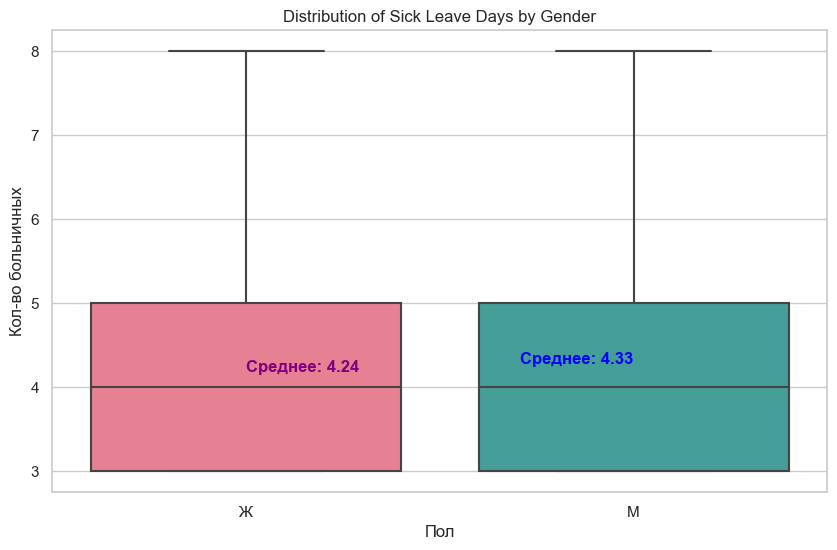

In [12]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='gender', y='work_days', data=data_filtered, palette='husl')

male_mean = work_days_m.mean()
female_mean = work_days_f.mean()

ax.text(1, male_mean, f'Среднее: {male_mean:.2f}', ha='right', va='center', color='blue', weight='bold')
ax.text(0, female_mean, f'Среднее: {female_mean:.2f}', ha='left', va='center', color='purple', weight='bold')
plt.title('Distribution of Sick Leave Days by Gender')
plt.xlabel('Пол')
plt.ylabel('Кол-во больничных')
plt.show()

Из графика не следует статистическая значимость, однако видно, что среднее кол-во больничных дней у мужчин больше. Так же заметим, что
в данных нет выбросов. Можно проверить гипотезу, используя t-Критерий Стьюдента. Проверим следующие условия:
1) Нормальность распределения средних в выборке
2) Равны ли дисперсии

### Нормальность распределения средних в выборке

Для проверки нормальности средних, посчитаем среднее для 200 рандомных выборок по 20 значений

In [13]:
np.random.seed(112)
means = [work_days_m.sample(30).mean() for _ in range(200)]

(array([ 3.,  4., 18., 23., 36., 34., 45., 17., 17.,  3.]),
 array([3.73333333, 3.85      , 3.96666667, 4.08333333, 4.2       ,
        4.31666667, 4.43333333, 4.55      , 4.66666667, 4.78333333,
        4.9       ]),
 <BarContainer object of 10 artists>)

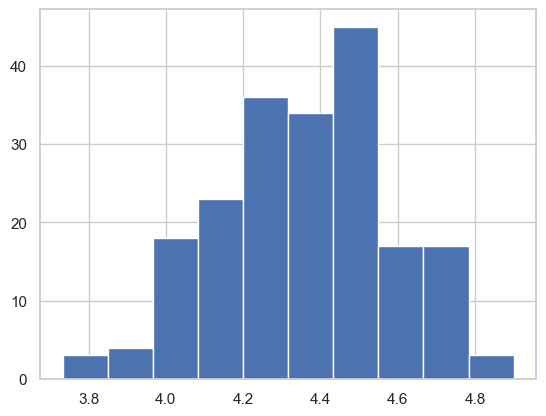

In [14]:
plt.hist(means)

Воспользуемя тестом Шапиро-Уилка и проверим среднии на нормальность

In [15]:
shapiro(means)

ShapiroResult(statistic=0.9911407232284546, pvalue=0.26053181290626526)

pvalue получилось больше 0.05, значит мы не можем отклонить гипотезу о нормальности. Аналогично для женщин:

In [16]:
np.random.seed(112)
means = [work_days_f.sample(30).mean() for _ in range(200)]

(array([ 3.,  5., 13., 19., 49., 41., 29., 26., 10.,  5.]),
 array([3.76666667, 3.85666667, 3.94666667, 4.03666667, 4.12666667,
        4.21666667, 4.30666667, 4.39666667, 4.48666667, 4.57666667,
        4.66666667]),
 <BarContainer object of 10 artists>)

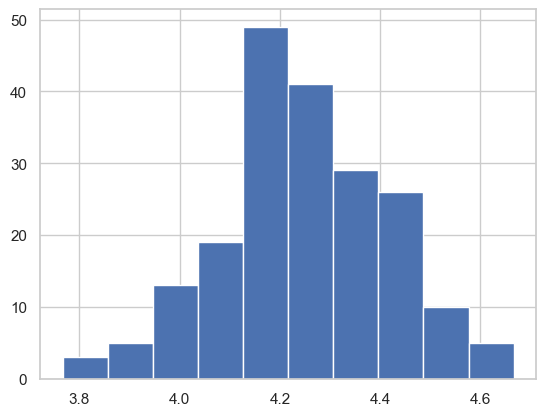

In [17]:
plt.hist(means)

In [18]:
shapiro(means)

ShapiroResult(statistic=0.9923462271690369, pvalue=0.3801189959049225)

### Равенство дисперсий

Для проверки будем использовать критерий Левене

In [19]:
levene(work_days_m, work_days_f)

LeveneResult(statistic=0.8103200070081782, pvalue=0.36947824611611746)

pvalue большой - принимаем гипотезу о равенстве дисперсий. Отразим равенство дисперсий в t-критерии

In [20]:
ttest_ind(work_days_m, work_days_f, equal_var=False)

TtestResult(statistic=0.42305776080458846, pvalue=0.6728666566797525, df=148.13300247041687)

pvalue получился больше уровня значимости, значит мы не можем отклонить нулевую гипотезу. Следовательно
нельзя сказать, что мужчины пропускают больше дней по больничному (чаще) чем женщины

## Проверим гипотезу о возрасте

Для этого сформулируем гипотезу $H_0$ - старше 35 и младше пропускают по больничному одинаково

In [21]:
work_days_greater_35 = data_filtered[data_filtered['age']>35]['work_days']
work_days_less_35 = data_filtered[data_filtered['age']<=35]['work_days']

data_filtered.loc[:, '>35'] = data_filtered.age > 35

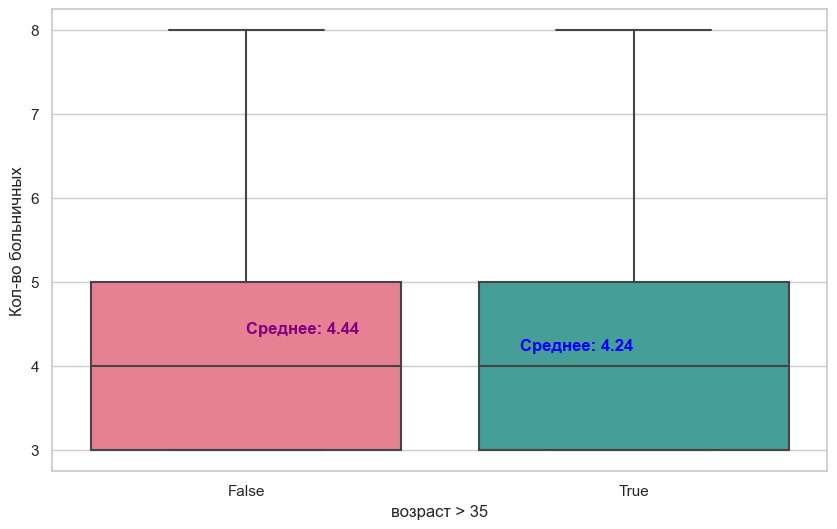

In [22]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='>35', y='work_days', data=data_filtered, palette='husl')

greater_35_mean = work_days_greater_35.mean()
less_35_mean = work_days_less_35.mean()

ax.text(1, greater_35_mean, f'Среднее: {greater_35_mean:.2f}', ha='right', va='center', color='blue', weight='bold')
ax.text(0, less_35_mean, f'Среднее: {less_35_mean:.2f}', ha='left', va='center', color='purple', weight='bold')
plt.xlabel('возраст > 35')
plt.ylabel('Кол-во больничных')
plt.show()

Аналогично проверим нормальность средних и равенство дисперсий для применения t-критерия:

### Нормальность распределения средних в выборке

In [23]:
np.random.seed(112)
means = [work_days_greater_35.sample(30).mean() for _ in range(200)]

(array([ 5.,  5., 13., 47., 38., 37., 30., 17.,  4.,  4.]),
 array([3.7 , 3.81, 3.92, 4.03, 4.14, 4.25, 4.36, 4.47, 4.58, 4.69, 4.8 ]),
 <BarContainer object of 10 artists>)

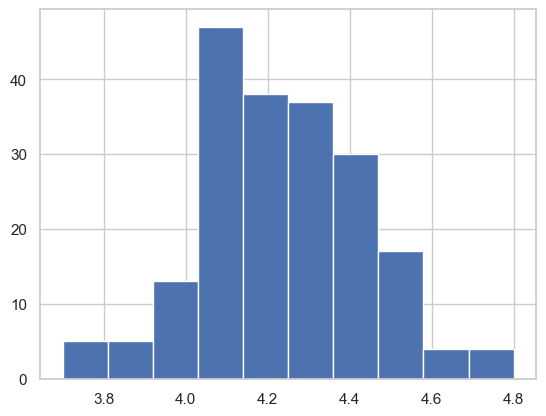

In [24]:
plt.hist(means)

In [25]:
shapiro(means)

ShapiroResult(statistic=0.9939770102500916, pvalue=0.5972183346748352)

In [26]:
np.random.seed(112)
means = [work_days_less_35.sample(20).mean() for _ in range(200)]

(array([ 2.,  6.,  9., 20., 21., 63., 31., 25., 15.,  8.]),
 array([3.8 , 3.91, 4.02, 4.13, 4.24, 4.35, 4.46, 4.57, 4.68, 4.79, 4.9 ]),
 <BarContainer object of 10 artists>)

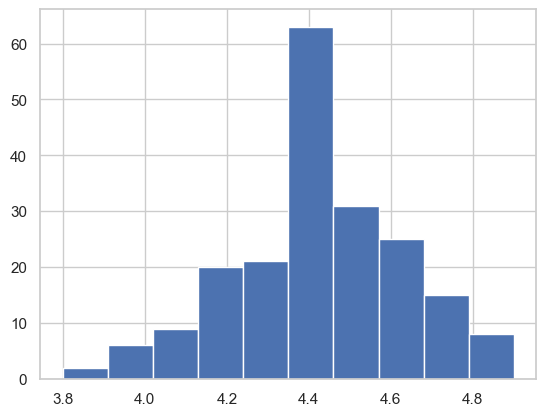

In [27]:
plt.hist(means)

In [28]:
shapiro(means)

ShapiroResult(statistic=0.9895867705345154, pvalue=0.15539772808551788)

Средние по выборкам распределены нормально в двух случаях

### Равенство дисперсий

In [29]:
levene(work_days_greater_35, work_days_less_35)

LeveneResult(statistic=0.002101465854705786, pvalue=0.963497765897437)

In [30]:
ttest_ind(work_days_greater_35, work_days_less_35, equal_var=True)

TtestResult(statistic=-0.7594348478395395, pvalue=0.4487922957971878, df=149.0)

pvalue получился больше уровня значимости, значит мы не можем отклонить нулевую гипотезу. Следовательно
нельзя сказать, что cотрудники старше 35 пропускают больше дней по больничному (чаще) чем младше

Таким образом, ни одна гипотеза не подтвердилась